In [1]:
#importing python libs

import sympy as sym
sym.init_printing()

import numpy as np
from math import pi
import math
import matplotlib.pyplot as plt
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct, Dagger
import scipy.optimize
import scipy.integrate
import scipy.constants as const

#import qutip

from matplotlib.colors import Normalize as Norm

import time
%load_ext cython

#==============================================
#define simulation parameters
filename='output_calcs/three_lvl_test1'
deltamacvals=np.linspace(-1000e6,1000e6,2)
deltamvals=np.linspace(-600e6,600e6,1)
deltaoval=1e7
binval=50
p = {}
p['nbath']=1

p['deltamu'] = 0.
p['deltao'] = 0.


p['d13'] = 2e-32*math.sqrt(1/3)
p['d23'] = 2e-32*math.sqrt(2/3)
p['gamma13'] = p['d13']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma23'] = p['d23']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma2d'] = 1e6
p['gamma3d'] = 1e6
#p['nbath'] = 20
p['gammamu'] = 1/(p['nbath']+1) * 1e3

p['go'] = 51.9  #optical coupling

p['No'] = 1.28e15 # number of atoms in the optical mode

p['deltac']=0 #detuning for
p['kappaoi']=2*pi*7.95e6 # intrinsic loss for optical resonator
p['kappaoc']=2*pi*1.7e6 # coupling loss for optical resonator
#p['df']=0.1e6 # how small descretisation step to take when integrating over the
            # inhomogeneous lines

p['mean_delam']=0
p['sd_delam']=2*pi*25e6/2.355  #microwave inhomogeneous broadening
                                #2.355is to turn FWHM into standard deviation
p['mean_delao']=0
p['sd_delao']=2*pi*170e6/2.355 #optical inhomogeneous broadening

p['kappami'] = 650e3*2*pi # intrinsic loss for microwave cavity
p['kappamc'] = 70e3*2*pi  # coupling loss for optical cavity
                        # this is for one of the two output ports
p['Nm'] = 2.22e16  #toal number of atoms
p['gm'] = 1.04 #coupling between atoms and microwave field

p['gammaoc']=2*pi*1.7e6
p['gammaoi']=2*pi*7.95e6
p['gammamc']=2*pi*70e3
p['gammami']=2*pi*650e3


muBohr=927.4009994e-26; # Bohr magneton in J/T in J* T^-1
p['mu12'] = 4.3803*muBohr # transition dipole moment for microwave cavity (J T^-1)

p['Lsample']=12e-3 # the length of the sample, in m
p['dsample']=5e-3 # the diameter of the sample, in m

p['fillfactor']=0.8 #microwave filling factor
p['freqmu'] = 5.186e9
p['freq_pump'] = 195113.36e9 #pump frequency
p['freqo']=p['freqmu']+p['freq_pump']

p['Lcavity_vac'] = 49.5e-3 # length of the vacuum part of the optical
                           # Fabry Perot (m)
p['Wcavity'] =  0.6e-3# width of optical resonator beam in sample (m)
p['nYSO'] = 1.76
p['Omega']=-492090.88755145477
#=====================================================
#define some s pre/post operators

def spre(m):
    return TensorProduct(sym.eye(m.shape[0]),m)

def spost(m):
    return TensorProduct(m.T, sym.eye(m.shape[0]))

def collapse(c):
    tmp = Dagger(c)*c/2
    return spre(c)*spost(Dagger(c))-spre(tmp)-spost(tmp)


s13=Matrix([[0,0,1],[0,0,0],[0,0,0]])
s23=Matrix([[0,0,0],[0,0,1],[0,0,0]])
s12=Matrix([[0,1,0],[0,0,0],[0,0,0]])

s31=s13.T
s32=s23.T
s21=s12.T

s11 = s12*s21
s22 = s21*s12
s33 = s31*s13

delo,delm=sym.symbols('delta_o delta_mu', real=True) #detunings between input and cavity
delta3,delta2=sym.symbols('delta_3 delta_2', real=True)

delao, delam =sym.symbols('delta_a_o delta_a_mu') #detunings between atom and cavity
gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu=sym.symbols('gamma_13 gamma_23 gamma_2d gamma_3d n_b gamma_mu', real=True, negative=False) #energy decay for atom levels
rho11, rho12, rho13, rho21, rho22, rho23, rho31, rho32, rho33=sym.symbols('rho_11 rho_12 rho_13 rho_21 rho_22 rho_23 rho_31 rho_32 rho_33') #Density matrix elements
a, b = sym.symbols('a b') #classical amplitudes of the optical and microwave fields
#ar,ai=sym.symbols('a_r a_i', real=True)
go, gm=sym.symbols('g_o, g_mu',real=True, negative=False) #coupling strengths for optical and microwave fields
Omega=sym.symbols('Omega', real=True) #pump Rabi frequency
lam=sym.symbols('lambda')

H_sys=Omega*s32+gm*s21*b+go*s31*a
H_sys=H_sys+Dagger(H_sys)
H_sys=H_sys+(delao -delo)*s33+(delam-delm)*s22

LH=-I*spre(H_sys)+I*spost(H_sys)
L21 = gammamu*(nbath+1)*collapse(s12)
L12 = gammamu*nbath*collapse(s21)
L32 = gamma23*collapse(s23)
L31 = gamma13*collapse(s13)
L22 = gamma2d*collapse(s22)
L33 = gamma3d*collapse(s33)

L=LH + L21 + L12 + L32 + L31 + L22 + L33

L = L.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))
L.row_del(1)

#define the density matrix in square and row form
#the row form is so the Liovillian in matrix form can be acted on it
rho = Matrix([[rho11,rho21,rho31],[rho12,rho22,rho32],[rho13,rho23,rho33]])
rho = 1*rho.T #because we are using "fortran" style matrix flatteneing
rho[:]
rhoflat = 1*rho.T
rhoflat = rhoflat[:]

Lfunc = sym.lambdify((a,b,delo, delm,delao, delam, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega,go,gm),L)


def steady_rho_single(delaoval,delamval,aval, bval,deloval,delmval,p):

    L_mat=Lfunc(aval, bval,deloval,delmval, delaoval,delamval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])
    rho = np.linalg.solve(L_mat.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    return np.reshape(rho,(3,3),order='F')

In [7]:
aa=np.array([[1.0,2.3,9000.7],[3.1,0.0,9]])
np.median(aa[aa!=0])

In [2]:
Lfunc

<function numpy.<lambda>(_Dummy_140, _Dummy_141, _Dummy_142, _Dummy_143, _Dummy_144, _Dummy_145, _Dummy_146, _Dummy_147, _Dummy_148, _Dummy_149, _Dummy_150, _Dummy_151, _Dummy_152, _Dummy_153, _Dummy_154)>

In [3]:
L

⎡   1                              0                                          
⎢                                                                             
⎢            γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                                   
⎢-ⅈ⋅b⋅gₘᵤ  - ──── - ─────── - ───────────── - ⅈ⋅(δₐ ₘᵤ - δₘᵤ)                 
⎢             2        2            2                                         
⎢                                                                             
⎢                                                                γ₁₃   γ₂₃   γ
⎢-ⅈ⋅a⋅gₒ                          -ⅈ⋅Ω                         - ─── - ─── - ─
⎢                                                                 2     2     
⎢                                                                             
⎢      _                                                                      
⎢ⅈ⋅gₘᵤ⋅b                           0                                          
⎢                                                   

In [4]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --verbose --force
#### %%cython -a # this gives "highligted" output

#cython: boundscheck=False, wraparound=False, nonecheck=False
cimport cython
import numpy as np
from cython.parallel cimport prange
cimport scipy.linalg.cython_lapack as lapack
import numpy as np
from libc.math cimport exp

[1/1] Cythonizing /home/peter/.cache/ipython/cython/_cython_magic_71524a40610d54e881801d13b78cf7ce.pyx
building '_cython_magic_71524a40610d54e881801d13b78cf7ce' extension
gcc -pthread -B /home/peter/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/peter/anaconda3/lib/python3.6/site-packages/numpy/core/include -I/home/peter/anaconda3/include/python3.6m -c /home/peter/.cache/ipython/cython/_cython_magic_71524a40610d54e881801d13b78cf7ce.c -o /home/peter/.cache/ipython/cython/home/peter/.cache/ipython/cython/_cython_magic_71524a40610d54e881801d13b78cf7ce.o -fopenmp
gcc -pthread -shared -B /home/peter/anaconda3/compiler_compat -L/home/peter/anaconda3/lib -Wl,-rpath=/home/peter/anaconda3/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/peter/.cache/ipython/cython/home/peter/.cache/ipython/cython/_cython_magic_71524a40610d54e881801d13b78cf7ce.o -o /home/peter/.cache/ipython/cython/_cython_magic_71524a40610d54e881801d13b78cf7c

In [5]:
for ii in range(81):
    print('' +'L[' +str(ii)+ '] =' +str(L[ii]))

L[0] =1
L[1] =0
L[2] =0
L[3] =0
L[4] =1
L[5] =0
L[6] =0
L[7] =0
L[8] =1
L[9] =-I*b*g_mu
L[10] =-gamma_2d/2 - gamma_mu*n_b/2 - gamma_mu*(n_b + 1)/2 - I*(delta_a_mu - delta_mu)
L[11] =-I*Omega
L[12] =0
L[13] =I*b*g_mu
L[14] =0
L[15] =0
L[16] =I*a*g_o
L[17] =0
L[18] =-I*a*g_o
L[19] =-I*Omega
L[20] =-gamma_13/2 - gamma_23/2 - gamma_3d/2 - gamma_mu*n_b/2 - I*(delta_a_o - delta_o)
L[21] =0
L[22] =0
L[23] =I*b*g_mu
L[24] =0
L[25] =0
L[26] =I*a*g_o
L[27] =I*g_mu*conjugate(b)
L[28] =0
L[29] =0
L[30] =-gamma_2d/2 - gamma_mu*n_b/2 - gamma_mu*(n_b + 1)/2 + I*(delta_a_mu - delta_mu)
L[31] =-I*g_mu*conjugate(b)
L[32] =-I*g_o*conjugate(a)
L[33] =I*Omega
L[34] =0
L[35] =0
L[36] =gamma_mu*n_b
L[37] =I*g_mu*conjugate(b)
L[38] =0
L[39] =-I*b*g_mu
L[40] =-gamma_mu*(n_b + 1)
L[41] =-I*Omega
L[42] =0
L[43] =I*Omega
L[44] =gamma_23
L[45] =0
L[46] =0
L[47] =I*g_mu*conjugate(b)
L[48] =-I*a*g_o
L[49] =-I*Omega
L[50] =-gamma_13/2 - gamma_23/2 - gamma_2d/2 - gamma_3d/2 - gamma_mu*(n_b + 1)/2 + I*(delta_a_mu - del

In [6]:
#change of variables to make things real to make it a bit faster maybe
CtoR = Matrix([[2,0,0,0,0,0,0,0,0],
               [0,0,0,0,2,0,0,0,0],
               [0,0,0,0,0,0,0,0,2],
               [0,1,0,1,0,0,0,0,0],
               [0,I,0,-I,0,0,0,0,0],
               [0,0,1,0,0,0,1,0,0],
               [0,0,I,0,0,0,-I,0,0],
               [0,0,0,0,0,1,0,1,0],
               [0,0,0,0,0,I,0,-I,0]
              ])
CtoR=CtoR/2

In [ ]:
V0,V1,V2,V3,V4,V5,V6,V7,V8=sym.symbols('V_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7 V_8')
Vmat=Matrix([V0,V1,V2,V3,V4,V5,V6,V7,V8])
CtoR.inv()*Vmat, Matrix(rhoflat)


In [7]:
Matrix([[V[0],V[3]-1j*V[4],V[5]-1j*V[6]],[V[3]+1j*V[4],V[1],V[7]-1j*V[8]],[V[5]+1j*V[6],V[7]+1j*V[8],V2]])
Matrix([[V[0],V[3]+1j*V[4],V[5]+1j*V[6]],[V[3]-1j*V[4],V[1],V[7]+1j*V[8]],[V[5]-1j*V[6],V[7]-1j*V[8],V2]])[0,1]

NameError: name 'V' is not defined

In [8]:
Matrix([V[0],V[3]-1j*V[4],V[5]-1j*V[6],V[3]+1j*V[4],V[1],V[7]-1j*V[8],V[5]+1j*V[6],V[7]+1j*V[8],V2])

NameError: name 'V' is not defined

In [146]:
Lreal = sym.simplify(CtoR*L*CtoR.inv())
#ar,ai,br,bi,gmr,gmi,gor,goi=sym.symbols('a_r a_i b_r b_i g_mu_r g_mu_i g_o_r g_o_i')
#agor,agoi, bgmr, bgmi,Wr,Wi=sym.symbols('ag_or ag_oi bg_mu_r bg_mu_i Omega_r Omega_i')
ar,ai,br,bi=sym.symbols('a_r a_i b_r b_i ')
#Lreal.subs({agor:(a*go+sym.conjugate(a)*sym.conjugate(go))/2,I*(sym.conjugate(a)*sym.conjugate(go)-a*go)/2:agoi})
#Lreal1=Lreal.subs({(a+sym.conjugate(a)):2*ar,(sym.conjugate(a)-a):2*I*ai,(b+sym.conjugate(b)):2*br,(sym.conjugate(b)-b):2*I*bi})
#Lreal = Lreal.subs(a,ar+I*ai)
Lreal=Lreal.subs({sym.conjugate(a):ar-I*ai,sym.conjugate(b):br-I*bi})
Lreal=Lreal.subs({a:ar+I*ai,b:br+I*bi})
Lreal
Lrealfunc = sym.lambdify((ar,ai,br,bi,delo, delm,delao, delam, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega,go,gm),Lreal)


In [147]:
Lreal

⎡   1           1             1                 0                       0     
⎢                                                                             
⎢γₘᵤ⋅n_b  -γₘᵤ⋅(n_b + 1)     γ₂₃             2⋅bᵢ⋅gₘᵤ                2⋅bᵣ⋅gₘᵤ 
⎢                                                                             
⎢   0           0         -γ₁₃ - γ₂₃            0                       0     
⎢                                                                             
⎢                                       γ_2d             γₘᵤ                  
⎢bᵢ⋅gₘᵤ      -bᵢ⋅gₘᵤ          0       - ──── - γₘᵤ⋅n_b - ───       -δₐ ₘᵤ + δₘ
⎢                                        2                2                   
⎢                                                                             
⎢                                                               γ_2d          
⎢bᵣ⋅gₘᵤ      -bᵣ⋅gₘᵤ          0            δₐ ₘᵤ - δₘᵤ        - ──── - γₘᵤ⋅n_b
⎢                                                   

In [133]:
Lreal.subs({ar:(a+sym.conjugate(a))/2,ai:(sym.conjugate(a)-a)/2,br:(b+sym.conjugate(b))/2,bi:(sym.conjugate(b)-b)/2})

⎡                 1                          1                           1    
⎢                                                                             
⎢                                                                             
⎢              γₘᵤ⋅n_b                 -γₘᵤ⋅(n_b + 1)                   γ₂₃   
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                 0                          0                       -γ₁₃ - γ₂
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                 ⎛     _⎞                   ⎛    _⎞

In [10]:
print('   '+str(Lreal[24]))

   2*a_r*g_o


In [11]:
go

In [148]:
ac,bc=sym.symbols('a_c b_c')
for ii in range(81):
    print('    ' +'L[' +str(ii)+ '] =' +str(L.subs({sym.conjugate(a):ac,sym.conjugate(b):bc}).T[ii]))

    L[0] =1
    L[1] =-I*b*g_mu
    L[2] =-I*a*g_o
    L[3] =I*b_c*g_mu
    L[4] =gamma_mu*n_b
    L[5] =0
    L[6] =I*a_c*g_o
    L[7] =0
    L[8] =0
    L[9] =0
    L[10] =-gamma_2d/2 - gamma_mu*n_b/2 - gamma_mu*(n_b + 1)/2 - I*(delta_a_mu - delta_mu)
    L[11] =-I*Omega
    L[12] =0
    L[13] =I*b_c*g_mu
    L[14] =0
    L[15] =0
    L[16] =I*a_c*g_o
    L[17] =0
    L[18] =0
    L[19] =-I*Omega
    L[20] =-gamma_13/2 - gamma_23/2 - gamma_3d/2 - gamma_mu*n_b/2 - I*(delta_a_o - delta_o)
    L[21] =0
    L[22] =0
    L[23] =I*b_c*g_mu
    L[24] =0
    L[25] =0
    L[26] =I*a_c*g_o
    L[27] =0
    L[28] =0
    L[29] =0
    L[30] =-gamma_2d/2 - gamma_mu*n_b/2 - gamma_mu*(n_b + 1)/2 + I*(delta_a_mu - delta_mu)
    L[31] =-I*b*g_mu
    L[32] =-I*a*g_o
    L[33] =I*Omega
    L[34] =0
    L[35] =0
    L[36] =1
    L[37] =I*b*g_mu
    L[38] =0
    L[39] =-I*b_c*g_mu
    L[40] =-gamma_mu*(n_b + 1)
    L[41] =-I*Omega
    L[42] =0
    L[43] =I*Omega
    L[44] =0
    L[45] =0
    L[46] =0
    

In [151]:
for ii in range(81):
    #if Lreal[ii]!=0:
    print('    ' +'Lreal[' +str(ii)+ '] =' +str(Lreal.T[ii]))

    Lreal[0] =1
    Lreal[1] =gamma_mu*n_b
    Lreal[2] =0
    Lreal[3] =b_i*g_mu
    Lreal[4] =b_r*g_mu
    Lreal[5] =a_i*g_o
    Lreal[6] =a_r*g_o
    Lreal[7] =0
    Lreal[8] =0
    Lreal[9] =1
    Lreal[10] =-gamma_mu*(n_b + 1)
    Lreal[11] =0
    Lreal[12] =-b_i*g_mu
    Lreal[13] =-b_r*g_mu
    Lreal[14] =0
    Lreal[15] =0
    Lreal[16] =0
    Lreal[17] =Omega
    Lreal[18] =1
    Lreal[19] =gamma_23
    Lreal[20] =-gamma_13 - gamma_23
    Lreal[21] =0
    Lreal[22] =0
    Lreal[23] =-a_i*g_o
    Lreal[24] =-a_r*g_o
    Lreal[25] =0
    Lreal[26] =-Omega
    Lreal[27] =0
    Lreal[28] =2*b_i*g_mu
    Lreal[29] =0
    Lreal[30] =-gamma_2d/2 - gamma_mu*n_b - gamma_mu/2
    Lreal[31] =delta_a_mu - delta_mu
    Lreal[32] =0
    Lreal[33] =Omega
    Lreal[34] =a_i*g_o
    Lreal[35] =a_r*g_o
    Lreal[36] =0
    Lreal[37] =2*b_r*g_mu
    Lreal[38] =0
    Lreal[39] =-delta_a_mu + delta_mu
    Lreal[40] =-gamma_2d/2 - gamma_mu*n_b - gamma_mu/2
    Lreal[41] =-Omega
    Lreal[42] =0
   

In [150]:
for ii in range(81):
    #if Lreal[ii]!=0:
    print('    ' +'Lreal[' +str(ii)+ '] =' +str(Lreal[ii]))

    Lreal[0] =1
    Lreal[1] =1
    Lreal[2] =1
    Lreal[3] =0
    Lreal[4] =0
    Lreal[5] =0
    Lreal[6] =0
    Lreal[7] =0
    Lreal[8] =0
    Lreal[9] =gamma_mu*n_b
    Lreal[10] =-gamma_mu*(n_b + 1)
    Lreal[11] =gamma_23
    Lreal[12] =2*b_i*g_mu
    Lreal[13] =2*b_r*g_mu
    Lreal[14] =0
    Lreal[15] =0
    Lreal[16] =0
    Lreal[17] =-2*Omega
    Lreal[18] =0
    Lreal[19] =0
    Lreal[20] =-gamma_13 - gamma_23
    Lreal[21] =0
    Lreal[22] =0
    Lreal[23] =2*a_i*g_o
    Lreal[24] =2*a_r*g_o
    Lreal[25] =0
    Lreal[26] =2*Omega
    Lreal[27] =b_i*g_mu
    Lreal[28] =-b_i*g_mu
    Lreal[29] =0
    Lreal[30] =-gamma_2d/2 - gamma_mu*n_b - gamma_mu/2
    Lreal[31] =-delta_a_mu + delta_mu
    Lreal[32] =0
    Lreal[33] =-Omega
    Lreal[34] =-a_i*g_o
    Lreal[35] =-a_r*g_o
    Lreal[36] =b_r*g_mu
    Lreal[37] =-b_r*g_mu
    Lreal[38] =0
    Lreal[39] =delta_a_mu - delta_mu
    Lreal[40] =-gamma_2d/2 - gamma_mu*n_b - gamma_mu/2
    Lreal[41] =Omega
    Lreal[42] =0
    Lre

In [ ]:
%reload_ext cython

In [ ]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --verbose --force
#### %%cython -a # this gives "highligted" output

#cython: boundscheck=False, wraparound=False, nonecheck=False
cimport cython
import numpy as np
from cython.parallel cimport prange
cimport scipy.linalg.cython_lapack as lapack
import numpy as np
from libc.math cimport exp
import scipy.special.roots_legendre
#cdef double complex steady_rhoc1[3](double a_r):
#    cdef int aa = 2
#    cdef double bb[3]
#    bb[2]=a_r*aa
#    return bb
#hh=steady_rhoc1(1.9)    
#print('  ' +str(hh))
#def Lfuncflat(aval, bval,deloval,delmval, delaoval,delamval,p):
#    return Lfunc(aval, bval,deloval,delmval, delaoval,delamval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm']).T.flatten()

def steady_rho_single_c(double delta_a_o, double delta_a_mu, double complex aval,double complex bval,double delta_o,double delta_mu,p):

    cdef double Lreal[81]
    cdef double V[9]
    cdef int workspacec[9]
    cdef int info
    cdef int lda = 9
    cdef int ldb = 9 
    cdef int nrhs = 1
    cdef int n = 9
    cdef double gamma_13 = p['gamma13']
    cdef double gamma_23 = p['gamma23'] 
    cdef double gamma_2d = p['gamma2d']
    cdef double gamma_3d = p['gamma3d']
    cdef double n_b = p['nbath']
    cdef double gamma_mu = p['gammamu']
    cdef double g_mu = p['gm']
    cdef double g_o = p['go']
    cdef double Omega = p['Omega']
    cdef double a_r=aval.real
    cdef double a_i=aval.imag
    cdef double b_r=bval.real
    cdef double b_i=bval.imag
    V[:]=[1,0,0, 0,0,0, 0,0,0]
    
    Lreal[0] =1
    Lreal[1] =gamma_mu*n_b
    Lreal[2] =0
    Lreal[3] =-b_i*g_mu
    Lreal[4] =b_r*g_mu
    Lreal[5] =-a_i*g_o
    Lreal[6] =a_r*g_o
    Lreal[7] =0
    Lreal[8] =0
    Lreal[9] =1
    Lreal[10] =-gamma_mu*(n_b + 1)
    Lreal[11] =0
    Lreal[12] =b_i*g_mu
    Lreal[13] =-b_r*g_mu
    Lreal[14] =0
    Lreal[15] =0
    Lreal[16] =0
    Lreal[17] =Omega
    Lreal[18] =1
    Lreal[19] =gamma_23
    Lreal[20] =-gamma_13 - gamma_23
    Lreal[21] =0
    Lreal[22] =0
    Lreal[23] =a_i*g_o
    Lreal[24] =-a_r*g_o
    Lreal[25] =0
    Lreal[26] =-Omega
    Lreal[27] =0
    Lreal[28] =-2*b_i*g_mu
    Lreal[29] =0
    Lreal[30] =-gamma_2d/2 - gamma_mu*n_b - gamma_mu/2
    Lreal[31] =delta_a_mu - delta_mu
    Lreal[32] =0
    Lreal[33] =Omega
    Lreal[34] =-a_i*g_o
    Lreal[35] =a_r*g_o
    Lreal[36] =0
    Lreal[37] =2*b_r*g_mu
    Lreal[38] =0
    Lreal[39] =-delta_a_mu + delta_mu
    Lreal[40] =-gamma_2d/2 - gamma_mu*n_b - gamma_mu/2
    Lreal[41] =-Omega
    Lreal[42] =0
    Lreal[43] =a_r*g_o
    Lreal[44] =a_i*g_o
    Lreal[45] =0
    Lreal[46] =0
    Lreal[47] =-2*a_i*g_o
    Lreal[48] =0
    Lreal[49] =Omega
    Lreal[50] =-gamma_13/2 - gamma_23/2 - gamma_3d/2 - gamma_mu*n_b/2
    Lreal[51] =delta_a_o - delta_o
    Lreal[52] =-b_i*g_mu
    Lreal[53] =-b_r*g_mu
    Lreal[54] =0
    Lreal[55] =0
    Lreal[56] =2*a_r*g_o
    Lreal[57] =-Omega
    Lreal[58] =0
    Lreal[59] =-delta_a_o + delta_o
    Lreal[60] =-gamma_13/2 - gamma_23/2 - gamma_3d/2 - gamma_mu*n_b/2
    Lreal[61] =b_r*g_mu
    Lreal[62] =-b_i*g_mu
    Lreal[63] =0
    Lreal[64] =0
    Lreal[65] =0
    Lreal[66] =a_i*g_o
    Lreal[67] =-a_r*g_o
    Lreal[68] =b_i*g_mu
    Lreal[69] =-b_r*g_mu
    Lreal[70] =-gamma_13/2 - gamma_23/2 - gamma_2d/2 - gamma_3d/2 - gamma_mu*(n_b + 1)/2
    Lreal[71] =-delta_a_mu + delta_a_o + delta_mu - delta_o
    Lreal[72] =0
    Lreal[73] =-2*Omega
    Lreal[74] =2*Omega
    Lreal[75] =-a_r*g_o
    Lreal[76] =-a_i*g_o
    Lreal[77] =b_r*g_mu
    Lreal[78] =b_i*g_mu
    Lreal[79] =delta_a_mu - delta_a_o - delta_mu + delta_o
    Lreal[80] =-gamma_13/2 - gamma_23/2 - gamma_2d/2 - gamma_3d/2 - gamma_mu*(n_b + 1)/2
    
    #rho = np.linalg.solve(L_mat.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    lapack.dgesv(&n,&nrhs,Lreal,&lda,workspacec,V,&ldb, &info)
    #lapack.dgesv(&n,&nrhs,L,&lda,workspace,V,&ldb,&info)
    #return V
    #return [V[3]+1j*V[4],V[5]+1j*V[6]]
    return np.array([[V[0],V[3]+1j*V[4],V[5]+1j*V[6]],[V[3]-1j*V[4],V[1],V[7]+1j*V[8]],[V[5]-1j*V[6],V[7]-1j*V[8],V[2]]])

def

In [ ]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --verbose --force
#### %%cython -a # this gives "highligted" output

#cython: boundscheck=False, wraparound=False, nonecheck=False
cimport cython
import numpy as np
from cython.parallel cimport prange
cimport scipy.linalg.cython_lapack as lapack
import numpy as np
from libc.math cimport exp

#cdef double complex steady_rhoc1[3](double a_r):
#    cdef int aa = 2
#    cdef double bb[3]
#    bb[2]=a_r*aa
#    return bb
#hh=steady_rhoc1(1.9)    
#print('  ' +str(hh))
#def Lfuncflat(aval, bval,deloval,delmval, delaoval,delamval,p):
#    return Lfunc(aval, bval,deloval,delmval, delaoval,delamval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm']).T.flatten()
cdef convert_to_python(double *ptr, int n):
    cdef int i
    lst=[]
    for i in range(n):
        lst.append(ptr[i])
    return lst
def steady_rho_single_csvd(double delta_a_o, double delta_a_mu, double complex a,double complex b,double delta_o,double delta_mu,p):

    
    cdef int m = 9
    cdef int n = 9
    cdef int lda = 9 
    cdef double* s#=[0,0,0, 0,0,0, 0,0,0]
    cdef double complex u#[81]
    cdef int ldu =9
    cdef double complex vt#[81]
    cdef int ldvt =9
    cdef double complex workspacec#[27]
    cdef int lwork = -1#27
    cdef double rwork#[45]
    cdef int info
    cdef char jobu = b"N"
    cdef char jobvt = b"S"
    
    cdef double complex L[81]
    cdef double complex I = 1j
    cdef double complex a_c = a.conjugate()
    cdef double complex b_c = b.conjugate()
    cdef double gamma_13 = p['gamma13']
    cdef double gamma_23 = p['gamma23'] 
    cdef double gamma_2d = p['gamma2d']
    cdef double gamma_3d = p['gamma3d']
    cdef double n_b = p['nbath']
    cdef double gamma_mu = p['gammamu']
    cdef double g_mu = p['gm']
    cdef double g_o = p['go']
    cdef double Omega = p['Omega']
    
    #s[:]=[0,0,0, 0,0,0, 0,0,0]
    
    L[0] =1
    L[1] =-I*b*g_mu
    L[2] =-I*a*g_o
    L[3] =I*b_c*g_mu
    L[4] =gamma_mu*n_b
    L[5] =0
    L[6] =I*a_c*g_o
    L[7] =0
    L[8] =0
    L[9] =0
    L[10] =-gamma_2d/2 - gamma_mu*n_b/2 - gamma_mu*(n_b + 1)/2 - I*(delta_a_mu - delta_mu)
    L[11] =-I*Omega
    L[12] =0
    L[13] =I*b_c*g_mu
    L[14] =0
    L[15] =0
    L[16] =I*a_c*g_o
    L[17] =0
    L[18] =0
    L[19] =-I*Omega
    L[20] =-gamma_13/2 - gamma_23/2 - gamma_3d/2 - gamma_mu*n_b/2 - I*(delta_a_o - delta_o)
    L[21] =0
    L[22] =0
    L[23] =I*b_c*g_mu
    L[24] =0
    L[25] =0
    L[26] =I*a_c*g_o
    L[27] =0
    L[28] =0
    L[29] =0
    L[30] =-gamma_2d/2 - gamma_mu*n_b/2 - gamma_mu*(n_b + 1)/2 + I*(delta_a_mu - delta_mu)
    L[31] =-I*b*g_mu
    L[32] =-I*a*g_o
    L[33] =I*Omega
    L[34] =0
    L[35] =0
    L[36] =1
    L[37] =I*b*g_mu
    L[38] =0
    L[39] =-I*b_c*g_mu
    L[40] =-gamma_mu*(n_b + 1)
    L[41] =-I*Omega
    L[42] =0
    L[43] =I*Omega
    L[44] =0
    L[45] =0
    L[46] =0
    L[47] =I*b*g_mu
    L[48] =-I*a_c*g_o
    L[49] =-I*Omega
    L[50] =-gamma_13/2 - gamma_23/2 - gamma_2d/2 - gamma_3d/2 - gamma_mu*(n_b + 1)/2 + I*(delta_a_mu - delta_mu) - I*(delta_a_o - delta_o)
    L[51] =0
    L[52] =0
    L[53] =I*Omega
    L[54] =0
    L[55] =0
    L[56] =0
    L[57] =I*Omega
    L[58] =0
    L[59] =0
    L[60] =-gamma_13/2 - gamma_23/2 - gamma_3d/2 - gamma_mu*n_b/2 + I*(delta_a_o - delta_o)
    L[61] =-I*b*g_mu
    L[62] =-I*a*g_o
    L[63] =0
    L[64] =I*a*g_o
    L[65] =0
    L[66] =0
    L[67] =I*Omega
    L[68] =0
    L[69] =-I*b_c*g_mu
    L[70] =-gamma_13/2 - gamma_23/2 - gamma_2d/2 - gamma_3d/2 - gamma_mu*(n_b + 1)/2 - I*(delta_a_mu - delta_mu) + I*(delta_a_o - delta_o)
    L[71] =-I*Omega
    L[72] =1
    L[73] =0
    L[74] =I*a*g_o
    L[75] =0
    L[76] =gamma_23
    L[77] =I*Omega
    L[78] =-I*a_c*g_o
    L[79] =-I*Omega
    L[80] =-gamma_13 - gamma_23
    #cdef int m = 9
    #cdef int n = 9
    #cdef int lda = 9 
    #cdef double s[9]
    #cdef double complex u[81]
    #cdef int ldu =9
    #cdef complex double vt[81]
    #cdef int ldvt =1
    #cdef double complex workspacec[27]
    #cdef int lwork = 27
    #cdef double rwork[45]
    ##cdef int workspace
    #cdef int info
    lapack.zgesvd(&jobu,&jobvt,&m,&n,L,&lda,s,&u,&ldu,&vt,&ldvt,&workspacec,&lwork,&rwork,&info)
    #rho = np.linalg.solve(L_mat.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    #lapack.dgesv(&n,&nrhs,Lreal,&lda,workspacec,V,&ldb, &info)
    #lapack.dgesv(&n,&nrhs,L,&lda,workspace,V,&ldb,&info)
    #return V
    #return [V[3]+1j*V[4],V[5]+1j*V[6]]
    return convert_to_python(s)
#steady_rho_single_c(10e7, -2e7, 5,50,0,0,p)

In [ ]:
#np.reshape(steady_rho_single_csvd(delaoval, delamval, 5,50,10e7,3e8,p)[0],(9,9)),
steady_rho_single_csvd(delaoval, delamval, 5,50,10e7,3e8,p)

In [ ]:
delaovals=np.linspace(-10e7,10e7,400)
delamvals=np.linspace(-10e7,10e7,400)
time1=time.time()
for ii, delaoval in enumerate(delaovals):
    for jj, delamval in enumerate(delamvals):
        rho1=steady_rho_single_c(delaoval, delamval, 5,50,10e7,3e8,p)
        #print('  '+str(rho1))
time_el1=time.time()-time1
print('  '+str(time_el1))
        
time1=time.time()
for ii, delaoval in enumerate(delaovals):
    for jj, delamval in enumerate(delamvals):
        rho2=steady_rho_single(delaoval, delamval, 5,50,10e7,3e8,p)
        #print('  '+str(rho2))
time_el2=time.time()-time1
print('  '+str(time_el2))
print('  '+str(time_el2/time_el1))

In [7]:
%load_ext cython
import scipy.special
from math import pi
import math
#==============================================
#define simulation parameters
filename='output_calcs/three_lvl_test1'
deltamacvals=np.linspace(-1000e6,1000e6,2)
deltamvals=np.linspace(-600e6,600e6,1)
deltaoval=1e7
binval=50
p = {}
p['nbath']=1

p['deltamu'] = 0.
p['deltao'] = 0.


p['d13'] = 2e-32*math.sqrt(1/3)
p['d23'] = 2e-32*math.sqrt(2/3)
p['gamma13'] = p['d13']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma23'] = p['d23']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma2d'] = 1e6
p['gamma3d'] = 1e6
#p['nbath'] = 20
p['gammamu'] = 1/(p['nbath']+1) * 1e3

p['go'] = 51.9  #optical coupling

p['No'] = 1.28e15 # number of atoms in the optical mode

p['deltac']=0 #detuning for
p['kappaoi']=2*pi*7.95e6 # intrinsic loss for optical resonator
p['kappaoc']=2*pi*1.7e6 # coupling loss for optical resonator
#p['df']=0.1e6 # how small descretisation step to take when integrating over the
            # inhomogeneous lines

p['mean_delam']=0
p['sd_delam']=2*pi*25e6/2.355  #microwave inhomogeneous broadening
                                #2.355is to turn FWHM into standard deviation
p['mean_delao']=0
p['sd_delao']=2*pi*170e6/2.355 #optical inhomogeneous broadening

p['kappami'] = 650e3*2*pi # intrinsic loss for microwave cavity
p['kappamc'] = 70e3*2*pi  # coupling loss for optical cavity
                        # this is for one of the two output ports
p['Nm'] = 2.22e16  #toal number of atoms
p['gm'] = 1.04 #coupling between atoms and microwave field

p['gammaoc']=2*pi*1.7e6
p['gammaoi']=2*pi*7.95e6
p['gammamc']=2*pi*70e3
p['gammami']=2*pi*650e3


muBohr=927.4009994e-26; # Bohr magneton in J/T in J* T^-1
p['mu12'] = 4.3803*muBohr # transition dipole moment for microwave cavity (J T^-1)

p['Lsample']=12e-3 # the length of the sample, in m
p['dsample']=5e-3 # the diameter of the sample, in m

p['fillfactor']=0.8 #microwave filling factor
p['freqmu'] = 5.186e9
p['freq_pump'] = 195113.36e9 #pump frequency
p['freqo']=p['freqmu']+p['freq_pump']

p['Lcavity_vac'] = 49.5e-3 # length of the vacuum part of the optical
                           # Fabry Perot (m)
p['Wcavity'] =  0.6e-3# width of optical resonator beam in sample (m)
p['nYSO'] = 1.76
p['Omega']=-492090.88755145477
#=====================================================

NameError: name 'np' is not defined

In [33]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --verbose --force
#### %%cython -a # this gives "highligted" output

#cython: boundscheck=False, wraparound=False, nonecheck=False
cimport cython
import numpy as np
from cython.parallel cimport prange
cimport scipy.linalg.cython_lapack as lapack
import numpy as np
from libc.math cimport exp, sqrt
import scipy.special#.roots_legendre

#cdef double complex steady_rhoc1[3](double a_r):
#    cdef int aa = 2
#    cdef double bb[3]
#    bb[2]=a_r*aa
#    return bb
#hh=steady_rhoc1(1.9)    
#print('  ' +str(hh))
#def Lfuncflat(aval, bval,deloval,delmval, delaoval,delamval,p):
#    return Lfunc(aval, bval,deloval,delmval, delaoval,delamval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm']).T.flatten()

def steady_rho_single_c(double delta_a_o, double delta_a_mu, double complex aval,double complex bval,double delta_o,double delta_mu,p):

    cdef double Lreal[81]
    cdef double V[9]
    cdef int workspacec[9]
    cdef int info
    cdef int lda = 9
    cdef int ldb = 9 
    cdef int nrhs = 1
    cdef int n = 9
    cdef double gamma_13 = p['gamma13']
    cdef double gamma_23 = p['gamma23'] 
    cdef double gamma_2d = p['gamma2d']
    cdef double gamma_3d = p['gamma3d']
    cdef double n_b = p['nbath']
    cdef double gamma_mu = p['gammamu']
    cdef double g_mu = p['gm']
    cdef double g_o = p['go']
    cdef double Omega = p['Omega']
    cdef double a_r=aval.real
    cdef double a_i=aval.imag
    cdef double b_r=bval.real
    cdef double b_i=bval.imag
    V[:]=[1,0,0, 0,0,0, 0,0,0]
    
    Lreal[0] =1
    Lreal[1] =gamma_mu*n_b
    Lreal[2] =0
    Lreal[3] =b_i*g_mu
    Lreal[4] =b_r*g_mu
    Lreal[5] =a_i*g_o
    Lreal[6] =a_r*g_o
    Lreal[7] =0
    Lreal[8] =0
    Lreal[9] =1
    Lreal[10] =-gamma_mu*(n_b + 1)
    Lreal[11] =0
    Lreal[12] =-b_i*g_mu
    Lreal[13] =-b_r*g_mu
    Lreal[14] =0
    Lreal[15] =0
    Lreal[16] =0
    Lreal[17] =Omega
    Lreal[18] =1
    Lreal[19] =gamma_23
    Lreal[20] =-gamma_13 - gamma_23
    Lreal[21] =0
    Lreal[22] =0
    Lreal[23] =-a_i*g_o
    Lreal[24] =-a_r*g_o
    Lreal[25] =0
    Lreal[26] =-Omega
    Lreal[27] =0
    Lreal[28] =2*b_i*g_mu
    Lreal[29] =0
    Lreal[30] =-gamma_2d/2 - gamma_mu*n_b - gamma_mu/2
    Lreal[31] =delta_a_mu - delta_mu
    Lreal[32] =0
    Lreal[33] =Omega
    Lreal[34] =a_i*g_o
    Lreal[35] =a_r*g_o
    Lreal[36] =0
    Lreal[37] =2*b_r*g_mu
    Lreal[38] =0
    Lreal[39] =-delta_a_mu + delta_mu
    Lreal[40] =-gamma_2d/2 - gamma_mu*n_b - gamma_mu/2
    Lreal[41] =-Omega
    Lreal[42] =0
    Lreal[43] =a_r*g_o
    Lreal[44] =-a_i*g_o
    Lreal[45] =0
    Lreal[46] =0
    Lreal[47] =2*a_i*g_o
    Lreal[48] =0
    Lreal[49] =Omega
    Lreal[50] =-gamma_13/2 - gamma_23/2 - gamma_3d/2 - gamma_mu*n_b/2
    Lreal[51] =delta_a_o - delta_o
    Lreal[52] =b_i*g_mu
    Lreal[53] =-b_r*g_mu
    Lreal[54] =0
    Lreal[55] =0
    Lreal[56] =2*a_r*g_o
    Lreal[57] =-Omega
    Lreal[58] =0
    Lreal[59] =-delta_a_o + delta_o
    Lreal[60] =-gamma_13/2 - gamma_23/2 - gamma_3d/2 - gamma_mu*n_b/2
    Lreal[61] =b_r*g_mu
    Lreal[62] =b_i*g_mu
    Lreal[63] =0
    Lreal[64] =0
    Lreal[65] =0
    Lreal[66] =-a_i*g_o
    Lreal[67] =-a_r*g_o
    Lreal[68] =-b_i*g_mu
    Lreal[69] =-b_r*g_mu
    Lreal[70] =-gamma_13/2 - gamma_23/2 - gamma_2d/2 - gamma_3d/2 - gamma_mu*(n_b + 1)/2
    Lreal[71] =-delta_a_mu + delta_a_o + delta_mu - delta_o
    Lreal[72] =0
    Lreal[73] =-2*Omega
    Lreal[74] =2*Omega
    Lreal[75] =-a_r*g_o
    Lreal[76] =a_i*g_o
    Lreal[77] =b_r*g_mu
    Lreal[78] =-b_i*g_mu
    Lreal[79] =delta_a_mu - delta_a_o - delta_mu + delta_o
    Lreal[80] =-gamma_13/2 - gamma_23/2 - gamma_2d/2 - gamma_3d/2 - gamma_mu*(n_b + 1)/2
    
    #rho = np.linalg.solve(L_mat.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    lapack.dgesv(&n,&nrhs,Lreal,&lda,workspacec,V,&ldb, &info)
    #lapack.dgesv(&n,&nrhs,L,&lda,workspace,V,&ldb,&info)
    return V
    #return [V[3]+1j*V[4],V[5]+1j*V[6]]
    #return np.array([[V[0],V[3]+1j*V[4],V[5]+1j*V[6]],[V[3]-1j*V[4],V[1],V[7]+1j*V[8]],[V[5]-1j*V[6],V[7]-1j*V[8],V[2]]])

def gauss_fun_1d(double x,double m, double sd):
    return 1.0/(sqrt(2*3.14159265358979323846)*sd)*exp(-(x-m)**2/(2*sd**2)) #2.5066282746310002 is sqrt(2*pi)


DEF n_gauss=15
DEF n_lag = 15
#global xgauss, wgauss
cdef double xgauss[n_gauss]
cdef double wgauss[n_gauss]
xgauss[:],wgauss[:]=scipy.special.roots_legendre(n_gauss)
cdef double xlag[n_lag]
cdef double wlag[n_lag]
xlag[:],wlag[:]=scipy.special.roots_laguerre(n_lag)


def rho_m_broad_single(double delaoval,double complex aval, double complex bval, double deloval,double delmval, p,delamlims):
    cdef double delamlimsc[2]
    delamlimsc[:]=delamlims
    #xvals, wvals = _cached_roots_legendre(n)
    cdef double yval#s[n_gauss]
    cdef double S_out[9]
    S_out[:]=[0,0,0, 0,0,0 ,0,0,0]
    cdef double rho_temp[9]
    cdef double gauss_weight
    cdef int ii
    cdef int jj
    cdef double mean_delam=p['mean_delam']
    cdef double sd_delam=p['sd_delam']
    #[yval[ii] = (delamlims[1]-delamlims[0])*(xgauss[ii]+1)/2.0 + delamlims[0] for ii in range(n_gauss)]
    
    #for ii in prange(n_gauss,nogil=True):
    for ii in range(n_gauss):
        yval=(delamlimsc[1]-delamlimsc[0])*(xgauss[ii]+1)/2.0 + delamlimsc[0]
        #gauss_weight=gauss_fun_1d(yval,p['mean_delam'],p['sd_delam'])*wgauss[ii]
        gauss_weight=gauss_fun_1d(yval,mean_delam,sd_delam)*wgauss[ii]
        rho_temp=(steady_rho_single_c(delaoval,yval,aval, bval,deloval,delmval,p))
        #S_out=[S_out[jj]+rho_temp[jj]*(delamlims[1]-delamlims[0])/2.0*gauss_weight for jj in range(9)]
        for jj in range(9):
            S_out[jj]+=rho_temp[jj]*(delamlimsc[1]-delamlimsc[0])/2.0*gauss_weight
    return S_out

#def rho_m_broad_full_bad(delaoval,aval,bval,deloval,delmval, p):
#    delamlims=[-50*p['sd_delam']+p['mean_delam'],50*p['sd_delam']+p['mean_delam']]
#    #splitpoints=[p['mean_delam'],delmval,-11*p['sd_delam']+p['mean_delam'],11*p['sd_delam']+p['mean_delam']]
#    ds_m=np.nan#find_dressed_states_m(delaoval, deloval,delmval,bval,p)[0].real
#    #ds_test=(steady_rho_single(delaoval,ds_m,aval, bval,deloval,delmval,p))
#    splitpoints=[p['mean_delam'],p['sd_delam']+p['mean_delam'] ,-p['sd_delam']+p['mean_delam'],delmval,delmval+2*p['gamma2d'],delmval-2*p['gamma2d']]#,p['sd_delam']+p['mean_delam']]
#    if not np.isnan(ds_m) and not ds_m in splitpoints:
#        splitpoints.append(ds_m)
#    points=np.array(sorted(np.hstack((delamlims[0],(splitpoints),delamlims[1])))
#    #print(ds_m)
#    #print(type(ds_m))
#    S_out_full=np.zeros((3,3),dtype=np.complex)
#    for ii in range(len(points)-1):
#       S_out_full=S_out_full+rho_m_broad_single(delaoval,aval,bval,deloval,delmval, p,[points[ii], points[ii+1]],n=n)
#    return S_out_full

def rho_m_broad_single_highbound(double delaoval,double complex aval, double complex bval, double deloval,double delmval, p,double delamlim):
    #xvals, wvals = _cached_roots_legendre(n)
    cdef double yval#s[n_gauss]
    cdef double S_out[9]
    S_out[:]=[0,0,0, 0,0,0 ,0,0,0]
    cdef double rho_temp[9]
    cdef double gaussexp_weight
    cdef int ii
    cdef int jj
    cdef double mean_delam=p['mean_delam']
    cdef double sd_delam=p['sd_delam']
    #[yval[ii] = (delamlims[1]-delamlims[0])*(xgauss[ii]+1)/2.0 + delamlims[0] for ii in range(n_gauss)]
    
    #for ii in prange(n_gauss,nogil=True):
    for ii in range(n_lag):
        yval=xlag[ii]-delamlim
        #gauss_weight=gauss_fun_1d(yval,p['mean_delam'],p['sd_delam'])*wgauss[ii]
        gaussexp_weight=gauss_fun_1d(yval,mean_delam,sd_delam)*wlag[ii]*exp(yval)
        rho_temp=(steady_rho_single_c(delaoval,yval,aval, bval,deloval,delmval,p))
        #S_out=[S_out[jj]+rho_temp[jj]*(delamlims[1]-delamlims[0])/2.0*gauss_weight for jj in range(9)]
        for jj in range(9):
            S_out[jj]+=rho_temp[jj]*gaussexp_weight
    return S_out
def rho_m_broad_single_lowbound(double delaoval,double complex aval, double complex bval, double deloval,double delmval, p,double delamlim):
    #xvals, wvals = _cached_roots_legendre(n)
    cdef double yval#s[n_gauss]
    cdef double S_out[9]
    S_out[:]=[0,0,0, 0,0,0 ,0,0,0]
    cdef double rho_temp[9]
    cdef double gaussexp_weight
    cdef int ii
    cdef int jj
    cdef double mean_delam=p['mean_delam']
    cdef double sd_delam=p['sd_delam']
    #[yval[ii] = (delamlims[1]-delamlims[0])*(xgauss[ii]+1)/2.0 + delamlims[0] for ii in range(n_gauss)]
    
    #for ii in prange(n_gauss,nogil=True):
    for ii in range(n_lag):
        yval=-xlag[ii]+delamlim
        #gauss_weight=gauss_fun_1d(yval,p['mean_delam'],p['sd_delam'])*wgauss[ii]
        gaussexp_weight=gauss_fun_1d(yval,mean_delam,sd_delam)*wlag[ii]*exp(yval)
        rho_temp=(steady_rho_single_c(delaoval,yval,aval, bval,deloval,delmval,p))
        #S_out=[S_out[jj]+rho_temp[jj]*(delamlims[1]-delamlims[0])/2.0*gauss_weight for jj in range(9)]
        for jj in range(9):
            S_out[jj]+=rho_temp[jj]*gaussexp_weight
    return S_out
           
def rho_m_broad_full(double delaoval,double complex aval, double complex bval,double deloval,double delmval, p):
    cdef double points[8]
    cdef double S_out[9]
    cdef double S_temp[9]
    cdef double pointpairs[2]
    cdef int ii,jj
    S_out=[0,0,0, 0,0,0, 0,0,0]
    points[:]=sorted([-50*p['sd_delam']+p['mean_delam'],50*p['sd_delam']+p['mean_delam'],p['mean_delam'],p['sd_delam']+p['mean_delam'] ,-p['sd_delam']+p['mean_delam'],delmval,delmval+2*p['gamma2d'],delmval-2*p['gamma2d']])#,p['sd_delam']+p['mean_delam']]
    #print(points)
    for ii in range(7):
        pointpairs[:]=[points[ii], points[ii+1]]
        S_temp=rho_m_broad_single(delaoval,aval,bval,deloval,delmval, p,pointpairs)
        #print(S_temp)
        S_out=[S_out[jj]+S_temp[jj] for jj in range(9)]
    S_temp=rho_m_broad_single_highbound(delaoval,aval,bval,deloval,delmval, p,points[7])
    S_out=[S_out[jj]+S_temp[jj] for jj in range(9)]
    S_temp=rho_m_broad_single_lowbound(delaoval,aval,bval,deloval,delmval, p,points[0])
    S_out=[S_out[jj]+S_temp[jj] for jj in range(9)]
    return S_out
                    
def rho_o_broad_single(double complex aval,double complex bval,double deloval,double delmval, p,delaolims):
    #xvals, wvals = _cached_roots_legendre(n)
    #yvals = (delaolims[1]-delaolims[0])*(xvals+1)/2.0 + delaolims[0]
    cdef double S_out[9]
    S_out[:]=[0,0,0, 0,0,0 ,0,0,0]
    cdef int ii, jj
    cdef double rho_temp[9]
    cdef double yval
    cdef double gauss_weight
    for ii in range(n_gauss):
        yval=(delaolims[1]-delaolims[0])*(xgauss[ii]+1)/2.0 + delaolims[0]
        gauss_weight=gauss_fun_1d(yval,p['mean_delao'],p['sd_delao'])*wgauss[ii]
        rho_temp=rho_m_broad_full(yval,aval, bval,deloval,delmval,p)
        S_out=[S_out[jj]+rho_temp[jj]*(delaolims[1]-delaolims[0])/2.0*gauss_weight for jj in range(9)]
    return S_out
def rho_o_broad_single_highbound(double complex aval,double complex bval,double deloval,double delmval, p, double delaolim):
    #xvals, wvals = _cached_roots_legendre(n)
    #yvals = (delaolims[1]-delaolims[0])*(xvals+1)/2.0 + delaolims[0]
    cdef double S_out[9]
    S_out[:]=[0,0,0, 0,0,0 ,0,0,0]
    cdef int ii, jj
    cdef double rho_temp[9]
    cdef double yval
    cdef double gaussexp_weight
    for ii in range(n_lag):
        yval=xlag[ii]-delaolim
        gaussexp_weight=gauss_fun_1d(yval,p['mean_delao'],p['sd_delao'])*wlag[ii]*exp(yval)
        rho_temp=rho_m_broad_full(yval,aval, bval,deloval,delmval,p)
        S_out=[S_out[jj]+rho_temp[jj]*gaussexp_weight for jj in range(9)]
    return S_out
def rho_o_broad_single_lowbound(double complex aval,double complex bval,double deloval,double delmval, p, double delaolim):
    #xvals, wvals = _cached_roots_legendre(n)
    #yvals = (delaolims[1]-delaolims[0])*(xvals+1)/2.0 + delaolims[0]
    cdef double S_out[9]
    S_out[:]=[0,0,0, 0,0,0 ,0,0,0]
    cdef int ii, jj
    cdef double rho_temp[9]
    cdef double yval
    cdef double gaussexp_weight
    for ii in range(n_lag):
        yval=-xlag[ii]+delaolim
        gaussexp_weight=gauss_fun_1d(yval,p['mean_delao'],p['sd_delao'])*wlag[ii]*exp(yval)
        rho_temp=rho_m_broad_full(yval,aval, bval,deloval,delmval,p)
        S_out=[S_out[jj]+rho_temp[jj]*gaussexp_weight for jj in range(9)]
    return S_out
def rho_broad_full(double complex aval,double complex bval,double deloval,double delmval, p):
    cdef double points[10]
    cdef double S_out_full[9]
    cdef double S_temp[9]
    cdef int ii,jj
    cdef double pointpairs[2]
    S_out_full=[0,0,0, 0,0,0, 0,0,0]
    points[:]=sorted([-50*p['sd_delao']+p['mean_delao'],50*p['sd_delao']+p['mean_delao'],p['mean_delao'],-3*p['sd_delao']+p['mean_delao'],3*p['sd_delao']+p['mean_delao'],-p['sd_delao']+p['mean_delao'],p['sd_delao']+p['mean_delao'],deloval,deloval+2*p['gamma3d'],deloval-2*p['gamma3d']])
    #points.sort()
    print(type(points))
    #for ii in prange(9,nogil=True):
    for ii in range(9):
        pointpairs[:]=[points[ii], points[ii+1]]
        S_temp=rho_o_broad_single(aval,bval,deloval,delmval, p,pointpairs)
        S_out_full=[S_out_full[jj]+S_temp[jj] for jj in range(9)]
    S_temp=rho_o_broad_single_highbound(aval,bval,deloval,delmval, p,points[9])
    S_out_full=[S_out_full[jj]+S_temp[jj] for jj in range(9)]
    S_temp=rho_o_broad_single_lowbound(aval,bval,deloval,delmval, p,points[0])
    S_out_full=[S_out_full[jj]+S_temp[jj] for jj in range(9)]
    #return S_out_full
    return [[S_out_full[0],S_out_full[3]+1j*S_out_full[4],S_out_full[5]+1j*S_out_full[6]],[S_out_full[3]-1j*S_out_full[4],S_out_full[1],S_out_full[7]+1j*S_out_full[8]],[S_out_full[5]-1j*S_out_full[6],S_out_full[7]-1j*S_out_full[8],S_out_full[2]]]
#def rho_integrate_full(double complex aval, double complex bval, double deloval, delmval,p):#, int n=15):
    #cdef int n=15
 #   cdef double points[10]
  #  cdef double complex S_out_full[9]
   # cdef double xvals[n_gauss]
    #cdef double yvals[n_gauss]
    #cdef double wvals[n_gauss]
    #cdef int ii
    #xvals[:],wvals[:] = scipy.special.roots_legendre(n_gauss)#_cached_roots_legendre(n_gauss)
    #points[:]=[-50*p['sd_delao']+p['mean_delao'],50*p['sd_delao']+p['mean_delao'],p['mean_delao'],-3*p['sd_delao']+p['mean_delao'],3*p['sd_delao']+p['mean_delao'],-p['sd_delao']+p['mean_delao'],p['sd_delao']+p['mean_delao'],deloval,deloval+2*p['gamma3d'],deloval-2*p['gamma3d']]
    #points.sort()
    #for ii in prange(9,nogil=True):
    #    1+1

[1/1] Cythonizing /home/peter/.cache/ipython/cython/_cython_magic_4b796b4095605070022ca0fd42f64902.pyx
building '_cython_magic_4b796b4095605070022ca0fd42f64902' extension
gcc -pthread -B /home/peter/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/peter/anaconda3/lib/python3.6/site-packages/numpy/core/include -I/home/peter/anaconda3/include/python3.6m -c /home/peter/.cache/ipython/cython/_cython_magic_4b796b4095605070022ca0fd42f64902.c -o /home/peter/.cache/ipython/cython/home/peter/.cache/ipython/cython/_cython_magic_4b796b4095605070022ca0fd42f64902.o -fopenmp
gcc -pthread -shared -B /home/peter/anaconda3/compiler_compat -L/home/peter/anaconda3/lib -Wl,-rpath=/home/peter/anaconda3/lib -Wl,--no-as-needed -Wl,--sysroot=/ /home/peter/.cache/ipython/cython/home/peter/.cache/ipython/cython/_cython_magic_4b796b4095605070022ca0fd42f64902.o -o /home/peter/.cache/ipython/cython/_cython_magic_4b796b4095605070022ca0fd42f6490

In [ ]:
rho_m_broad_single(5e6,5,50,1e7,-1.3e7, p,[-1e8,1e8])

In [233]:
rho_m_broad_full(5e6,5,50,1e7,-1.5e7, p)

In [ ]:
p

In [ ]:
rho_broad_full(5,50,10e7,3e8,p)

In [ ]:
import scipy.special
scipy.special.roots_legendre(15)

In [ ]:
xvals =np.linspace(-10e7,10e7,1000)
mvals=np.linspace(-10e7,10e7,1000)
sdvals=np.linspace(10,10e7,100)
t1=time.time()
for x in xvals:
    for m in mvals:
        for sd in sdvals:
            gauss_fun_1d(x,m,sd)
t2=time.time()
print('    ' + str(t2-t1))

In [ ]:
xvals =np.linspace(-10e7,10e7,100)
mvals=np.linspace(-10e7,10e7,100)
sdvals=np.linspace(10,10e7,100)
t1=time.time()
for x in xvals:
    for m in mvals:
        for sd in sdvals:
            gauss_fun_1d(x,m,sd)
t2=time.time()
print('    ' + str(t2-t1))

In [ ]:

np.sqrt(2*3.14159265358979323846)

In [ ]:

hh=[1,2,3,2]
hh+[3,2,4,2]

In [ ]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --verbose --force
#### %%cython -a # this gives "highligted" output

#cython: boundscheck=False, wraparound=False, nonecheck=False
cimport cython
cimport numpy as np
from cython.parallel cimport prange
cimport scipy.linalg.cython_lapack as lapack
import numpy as np
from libc.math cimport exp, sqrt
import scipy#.special.roots_legendre
import operator
cdef double h1[9]
h1[:]=[0,0,0, 6,7,0, 0,0,0]
cdef double h2[9]
h2[:]=sorted([9,8,3,4,5,6,7,8,9])
cdef double g1=9.9
cdef double g2=7.23
#h2.sort()
h1=[h1[jj]+h2[jj] for jj in range(9)]
print(h1)

In [166]:
delaovals=np.linspace(-2e7,2e7,21)
delamvals=np.linspace(-1e7,1e7,21)
aval=10+1j*10
bval=12-99.2*1j
deloval=0
delmval=0
rhoout=np.zeros((3,3,len(delaovals),len(delamvals)),dtype=np.complex_)
rhooutc=np.zeros((3,3,len(delaovals),len(delamvals)),dtype=np.complex_)
#steady_rho_single_c(double delta_a_o, double delta_a_mu, double complex aval,double complex bval,double delta_o,double delta_mu,p):
for ii, delaoval in enumerate(delaovals):
    for jj, delamval in enumerate(delamvals):
        rhoout[:,:,ii,jj]=steady_rho_single(delaoval,delamval,aval,bval,deloval,delmval,p)
        #V=np.reshape(steady_rho_single_c(delaoval,delamval,aval,bval,deloval,delmval,p),(3,3),order='F')
        #rhooutc[:,:,ii,jj]=np.array([[V[0],V[3]+1j*V[4],V[5]+1j*V[6]],[V[3]-1j*V[4],V[1],V[7]+1j*V[8]],[V[5]-1j*V[6],V[7]-1j*V[8],V[2]]])
        rhooutc[:,:,ii,jj]=np.reshape(np.matmul(np.array(CtoR.inv()).astype('complex128'),np.array(steady_rho_single_c(delaoval,delamval,aval,bval,deloval,delmval,p))),(3,3),order='F')

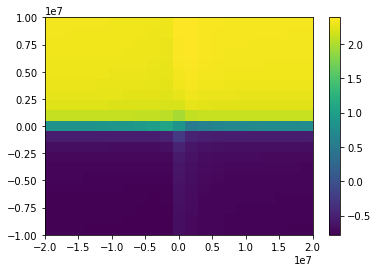

In [167]:
nn=2
plt.imshow(np.angle(rhooutc[0,nn,:,:]),extent=(np.min(delaovals),np.max(delaovals),np.min(delamvals),np.max(delamvals)),aspect='auto',origin='lower')
plt.colorbar()

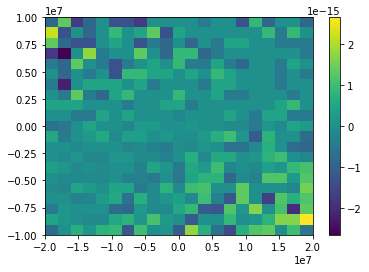

In [168]:
plt.imshow(np.angle(rhooutc[0,nn,:,:])-np.angle(rhoout[0,nn,:,:]),extent=(np.min(delaovals),np.max(delaovals),np.min(delamvals),np.max(delamvals)),aspect='auto',origin='lower')
plt.colorbar()

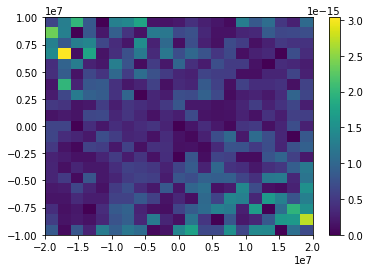

In [169]:
nn=2
plt.imshow((np.abs(rhooutc[0,nn,:,:]-rhoout[0,nn,:,:]))/np.abs(rhooutc[0,nn,:,:]),extent=(np.min(delaovals),np.max(delaovals),np.min(delamvals),np.max(delamvals)),aspect='auto',origin='lower')
plt.colorbar()

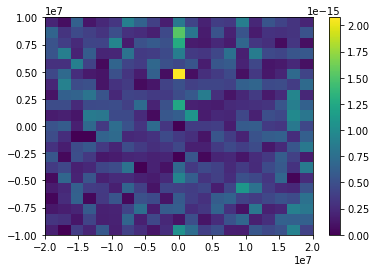

In [170]:
nn=1
plt.imshow((np.abs(rhooutc[0,nn,:,:]-rhoout[0,nn,:,:]))/np.abs(rhooutc[0,nn,:,:]),extent=(np.min(delaovals),np.max(delaovals),np.min(delamvals),np.max(delamvals)),aspect='auto',origin='lower')
plt.colorbar()

In [205]:
#importing python libs

import sympy as sym
sym.init_printing()

import numpy as np
from math import pi
import math
import matplotlib.pyplot as plt
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct, Dagger
import scipy.optimize
import scipy.integrate
import scipy.constants as const

#import qutip

from matplotlib.colors import Normalize as Norm

import time
def gauss_fun_1dp(x, m,sd):
    return 1.0/(np.sqrt(2*pi)*sd)*np.exp(-(x-m)**2/(2*sd**2))


def _cached_roots_legendre(n):
    """
    Cache roots_legendre results to speed up calls of the fixed_quad
    function.
    """
    if n in _cached_roots_legendre.cache:
        return _cached_roots_legendre.cache[n]

    _cached_roots_legendre.cache[n] = scipy.special.roots_legendre(n)
    return _cached_roots_legendre.cache[n]


_cached_roots_legendre.cache = dict()
def rho_m_broad_single_highbound(delaoval,aval,bval,deloval,delmval,p,delamlim,n_gauss=15):
    xvals,wvals=scipy.special.roots_laguerre(n_gauss)
    yvals=xvals-delamlim
    S_out=np.zeros((3,3),dtype=np.complex)
    for ii, yval in enumerate(yvals):
        S_out=S_out+(steady_rho_single(delaoval,yval,aval, bval,deloval,delmval,p))*gauss_fun_1dp(yval,p['mean_delam'],p['sd_delam'])*wvals[ii]*np.exp(yval)
    return S_out

def rho_m_broad_single_lowbound(delaoval,aval,bval,deloval,delmval,p,delamlim,n_gauss=15):
    xvals,wvals=scipy.special.roots_laguerre(n_gauss)
    yvals=-xvals+delamlim
    S_out=np.zeros((3,3),dtype=np.complex)
    for ii, yval in enumerate(yvals):
        S_out=S_out+(steady_rho_single(delaoval,yval,aval, bval,deloval,delmval,p))*gauss_fun_1dp(yval,p['mean_delam'],p['sd_delam'])*wvals[ii]*np.exp(yval)
    return S_out

def rho_m_broad_singlep(delaoval,aval,bval,deloval,delmval, p,delamlims,n=15):
    xvals, wvals = _cached_roots_legendre(n)
    yvals = (delamlims[1]-delamlims[0])*(xvals+1)/2.0 + delamlims[0]
    S_out=np.zeros((3,3),dtype=np.complex)
    for ii, yval in enumerate(yvals):
        S_out=S_out+(steady_rho_single(delaoval,yval,aval, bval,deloval,delmval,p))*gauss_fun_1dp(yval,p['mean_delam'],p['sd_delam'])*wvals[ii]
    return (delamlims[1]-delamlims[0])/2.0*S_out

def rho_m_broad_fullp(delaoval,aval,bval,deloval,delmval, p,n=15):
    delamlims=[-50*p['sd_delam']+p['mean_delam'],50*p['sd_delam']+p['mean_delam']]
    #splitpoints=[p['mean_delam'],delmval,-11*p['sd_delam']+p['mean_delam'],11*p['sd_delam']+p['mean_delam']]
    splitpoints=[p['mean_delam'],p['sd_delam']+p['mean_delam'] ,-p['sd_delam']+p['mean_delam'],delmval,delmval+2*p['gamma2d'],delmval-2*p['gamma2d']]#,p['sd_delam']+p['mean_delam']]

    points=np.hstack((delamlims[0],sorted(splitpoints),delamlims[1]))
    S_out_full=np.zeros((3,3),dtype=np.complex)
    for ii in range(len(points)-1):
        S_out_full=S_out_full+rho_m_broad_singlep(delaoval,aval,bval,deloval,delmval, p,[points[ii], points[ii+1]],n=n)
    S_out_full=S_out_full+rho_m_broad_single_lowbound(delaoval,aval,bval,deloval,delmval, p,points[0],n_gauss=n)+rho_m_broad_single_highbound(delaoval,aval,bval,deloval,delmval, p,points[-1],n_gauss=n)
    return S_out_full
def rho_o_broad_single_highbound(aval,bval,deloval,delmval, p,delaolim,n_gauss=15):
    xvals,wvals=scipy.special.roots_laguerre(n_gauss)
    yvals=xvals-delaolim
    S_out=np.zeros((3,3),dtype=np.complex)
    for ii, yval in enumerate(yvals):
        S_out=S_out+(rho_m_broad_fullp(yval,aval, bval,deloval,delmval,p,n=n_gauss))*gauss_fun_1dp(yval,p['mean_delao'],p['sd_delao'])*wvals[ii]*np.exp(yval)
    return S_out
    
def rho_o_broad_single_lowbound(aval,bval,deloval,delmval, p,delaolim,n_gauss=15):
    xvals,wvals=scipy.special.roots_laguerre(n_gauss)
    yvals=-xvals+delaolim
    S_out=np.zeros((3,3),dtype=np.complex)
    for ii, yval in enumerate(yvals):
        S_out=S_out+(rho_m_broad_fullp(yval,aval, bval,deloval,delmval,p,n=n_gauss))*gauss_fun_1dp(yval,p['mean_delao'],p['sd_delao'])*wvals[ii]*np.exp(yval)
    return S_out
        
def rho_o_broad_singlep(aval,bval,deloval,delmval, p,delaolims,n=15):
    xvals, wvals = _cached_roots_legendre(n)
    yvals = (delaolims[1]-delaolims[0])*(xvals+1)/2.0 + delaolims[0]
    S_out=np.zeros((3,3),dtype=np.complex)
    for ii, yval in enumerate(yvals):
        S_out=S_out+(rho_m_broad_fullp(yval,aval, bval,deloval,delmval,p,n=n))*gauss_fun_1dp(yval,p['mean_delao'],p['sd_delao'])*wvals[ii]
    return (delaolims[1]-delaolims[0])/2.0*S_out
def rho_broad_fullp(aval,bval,deloval,delmval, p,n=15):
    delaolims=[-50*p['sd_delao']+p['mean_delao'],50*p['sd_delao']+p['mean_delao']]
    splitpoints=[p['mean_delao'],-3*p['sd_delao']+p['mean_delao'],3*p['sd_delao']+p['mean_delao'],-p['sd_delao']+p['mean_delao'],p['sd_delao']+p['mean_delao'],deloval,deloval+2*p['gamma3d'],deloval-2*p['gamma3d']]
    #splitpoints=[p['mean_delao'],deloval]#,-11*p['sd_delao']+p['mean_delao'],11*p['sd_delao']+p['mean_delao']]
    #splitpoints=[p['mean_delao'],-2*p['sd_delao']+p['mean_delao'],2*p['sd_delao']+p['mean_delao'],deloval,deloval+2*p['gamma3d'],deloval-2*p['gamma3d']]

    points=np.hstack((delaolims[0],sorted(splitpoints),delaolims[1]))
    S_out_full=np.zeros((3,3),dtype=np.complex)
    for ii in range(len(points)-1):
        S_out_full=S_out_full+rho_o_broad_singlep(aval,bval,deloval,delmval, p,[points[ii], points[ii+1]],n=n)
    S_out_full=S_out_full+rho_o_broad_single_highbound(aval,bval,deloval,delmval, p,points[-1],n_gauss=n)+rho_o_broad_single_lowbound(aval,bval,deloval,delmval, p,points[0],n_gauss=n)
    return S_out_full

In [211]:
delovals=np.linspace(-1e8,1e8,5)
delmvals=np.linspace(-1e8,1e8,5)
aval=-9+1j*80
bval=500
delaoval=5e7
delamlims=[-0.1e7,1e8]
rhoiout=np.zeros((3,3,len(delovals),len(delmvals)),dtype=np.complex_)
rhoioutc=np.zeros((3,3,len(delovals),len(delmvals)),dtype=np.complex_)
#steady_rho_single_c(double delta_a_o, double delta_a_mu, double complex aval,double complex bval,double delta_o,double delta_mu,p):
for ii, deloval in enumerate(delovals):
    for jj, delmval in enumerate(delmvals):
        rhoiout[:,:,ii,jj]=rho_broad_fullp(aval,bval,deloval,delmval,p)
        rhoioutc[:,:,ii,jj]=rho_broad_full(aval,bval,deloval,delmval,p)
        #rhoiout[:,:,ii,jj]=rho_m_broad_singlep(delaoval,aval,bval,deloval,delmval, p,delamlims)
        #V=rho_m_broad_single(delaoval,aval,bval,deloval,delmval, p,delamlims)
        #rhoiout[:,:,ii,jj]=rho_m_broad_fullp(delaoval,aval,bval,deloval,delmval, p)
        #V=rho_m_broad_full(delaoval,aval,bval,deloval,delmval, p)
        #rhoioutc[:,:,ii,jj]=np.array([[V[0],V[3]+1j*V[4],V[5]+1j*V[6]],[V[3]-1j*V[4],V[1],V[7]+1j*V[8]],[V[5]-1j*V[6],V[7]-1j*V[8],V[2]]])

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [212]:
rhoiout

array([[[[ 6.33876829e-01+1.11307083e-17j,
           6.33369955e-01-1.15424466e-17j,
           6.33876930e-01+1.79516762e-18j,
           6.34651391e-01-1.45507082e-17j,
           6.36397071e-01-1.08245745e-17j],
         [ 6.34037270e-01+1.33446627e-17j,
           6.33204113e-01-1.53229267e-17j,
           6.33388486e-01+5.72808474e-18j,
           6.33855259e-01-6.36425042e-18j,
           6.35317646e-01-1.07537737e-17j],
         [ 6.34525729e-01+3.66265119e-18j,
           6.33369623e-01-2.52676966e-17j,
           6.33225467e-01+2.91907932e-17j,
           6.33369603e-01-1.37915481e-17j,
           6.34525698e-01+1.29389864e-17j],
         [ 6.35317677e-01+1.86192026e-18j,
           6.33855278e-01+8.45410737e-18j,
           6.33388485e-01+1.05487374e-17j,
           6.33204092e-01+1.02763226e-18j,
           6.34037239e-01-3.24900690e-17j],
         [ 6.36397101e-01+6.24416838e-18j,
           6.34651409e-01-3.04141612e-18j,
           6.33876928e-01+3.69071811e-17j,
       

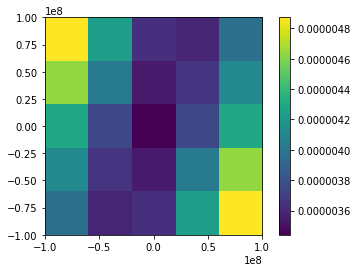

In [213]:
plt.imshow(np.abs(rhoiout[0,2,:,:]),extent=(np.min(delovals),np.max(delovals),np.min(delmvals),np.max(delmvals)),aspect='equal',origin='lower')
plt.colorbar()

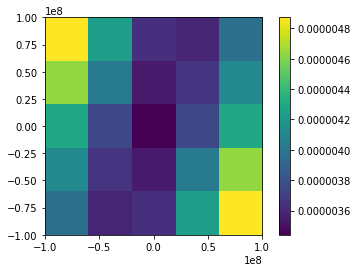

In [214]:
plt.imshow(np.abs(rhoioutc[0,2,:,:]),extent=(np.min(delovals),np.max(delovals),np.min(delmvals),np.max(delmvals)),aspect='equal',origin='lower')
plt.colorbar()

In [215]:
rhoiout

array([[[[ 6.33876829e-01+1.11307083e-17j,
           6.33369955e-01-1.15424466e-17j,
           6.33876930e-01+1.79516762e-18j,
           6.34651391e-01-1.45507082e-17j,
           6.36397071e-01-1.08245745e-17j],
         [ 6.34037270e-01+1.33446627e-17j,
           6.33204113e-01-1.53229267e-17j,
           6.33388486e-01+5.72808474e-18j,
           6.33855259e-01-6.36425042e-18j,
           6.35317646e-01-1.07537737e-17j],
         [ 6.34525729e-01+3.66265119e-18j,
           6.33369623e-01-2.52676966e-17j,
           6.33225467e-01+2.91907932e-17j,
           6.33369603e-01-1.37915481e-17j,
           6.34525698e-01+1.29389864e-17j],
         [ 6.35317677e-01+1.86192026e-18j,
           6.33855278e-01+8.45410737e-18j,
           6.33388485e-01+1.05487374e-17j,
           6.33204092e-01+1.02763226e-18j,
           6.34037239e-01-3.24900690e-17j],
         [ 6.36397101e-01+6.24416838e-18j,
           6.34651409e-01-3.04141612e-18j,
           6.33876928e-01+3.69071811e-17j,
       

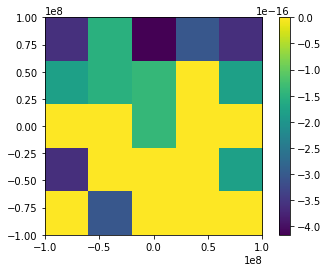

In [216]:
nn=1
plt.imshow((np.abs(rhoioutc[0,nn,:,:])-np.abs(rhoiout[0,nn,:,:]))/np.abs(rhoioutc[0,nn,:,:]),extent=(np.min(delovals),np.max(delovals),np.min(delmvals),np.max(delmvals)),aspect='equal',origin='lower')

plt.colorbar()

In [14]:
# calculate microwave rabi frequency from power in in dBm
def omegam_from_Pin(Pin,p):
    mu0 = 4*pi*1e-7
    hbar=1.05457e-34; # in J*s
    Vsample=pi*((p['dsample']/2)**2) * p['Lsample'] # the volume of the Er:YSO sample
    V_microwave_cavity = Vsample/p['fillfactor']    
    mwP = 1e-3 * 10**(Pin/10)  #convert from dBm to Watts
    Q=2*pi*p['freqmu']/(p['kappami']+p['kappamc']*2) # Q factor
    S21=(4*p['kappamc']**2)/(p['kappami']+p['kappamc']*2)**2
    energy_in_cavity=math.sqrt(S21)*2/(2*pi*p['freqmu']/Q)*mwP; # energy inside the microwave cavity, in J
    Bmw=math.sqrt(mu0*(energy_in_cavity/V_microwave_cavity)/2); # Magnetic field of the microwave
    p['omegam']=(p['mu12']*Bmw)/hbar*(-1); # in rad/sec???? in Hz
    return p['omegam']

In [19]:
def b_from_Pin(Pin,p):
    mu0=4*pi*1e-7
    hbar=1.05457e-34; # in J*s
    Vsample=pi*((p['dsample']/2)**2) * p['Lsample'] # the volume of the Er:YSO sample
    V_microwave_cavity=Vsample/p['fillfactor']
    mwP=1e-3*10**(Pin/10)
    Q=2*pi*p['freqmu']/(p['gammamc']+p['gammami'])
    S12=(p['gammamc']**2)/(p['gammamc']+p['gammami'])**2
    E_cavity=np.sqrt(S12)*2/(2*pi*p['freqmu']/Q)*mwP
    Bwm=np.sqrt(mu0*(E_cavity/V_microwave_cavity)/2)
    b=(p['mu12']*Bwm)/hbar
    return b
    

In [20]:
p={}
p['deltamu'] = 0.
p['deltao'] = 0.


p['d13'] = 2e-32*math.sqrt(1/3)
p['d23'] = 2e-32*math.sqrt(2/3)
p['gamma13'] = p['d13']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma23'] = p['d23']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma2d'] = 1e6
p['gamma3d'] = 1e6
p['nbath'] = 0.2
p['gammamu'] = 1/(p['nbath']+1) * 1e3

p['go'] = 51.9  #optical coupling

p['No'] = 1.28e15 # number of atoms in the optical mode

p['deltac']=0 #detuning for
p['kappaoi']=2*pi*7.95e6 # intrinsic loss for optical resonator
p['kappaoc']=2*pi*1.7e6 # coupling loss for optical resonator
#p['df']=0.1e6 # how small descretisation step to take when integrating over the
            # inhomogeneous lines

p['mean_delam']=0
p['sd_delam']=2*pi*2e6  #microwave inhomogeneous broadening
                                #2.355is to turn FWHM into standard deviation
p['mean_delao']=0
p['sd_delao']=2*pi*1000e6 #optical inhomogeneous broadening

p['kappami'] = 650e3*2*pi # intrinsic loss for microwave cavity
p['kappamc'] = 70e3*2*pi  # coupling loss for optical cavity
                        # this is for one of the two output ports
p['Nm'] = 2.22e16  #toal number of atoms
p['gm'] =  1.04 #coupling between atoms and microwave field

p['gammaoc']=2*pi*1.7e6
p['gammaoi']=2*pi*7.95e6
p['gammamc']=2*pi*0.0622e6
p['gammami']=2*pi*5.69e6


muBohr=927.4009994e-26; # Bohr magneton in J/T in J* T^-1
p['mu12'] = 4.3803*muBohr # transition dipole moment for microwave cavity (J T^-1)

p['Lsample']=12e-3 # the length of the sample, in m
p['dsample']=5e-3 # the diameter of the sample, in m

p['fillfactor']=0.8 #microwave filling factor
p['freqmu'] = 5.186e9
p['freq_pump'] = 195113.36e9 #pump frequency
p['freqo']=p['freqmu']+p['freq_pump']

p['Lcavity_vac'] = 49.5e-3 # length of the vacuum part of the optical
                           # Fabry Perot (m)
p['Wcavity'] =  0.6e-3# width of optical resonator beam in sample (m)
p['nYSO'] = 1.76
p['Omega']=-492090.88755145477


In [21]:
omegam_from_Pin(-15,p)

In [29]:
b_from_Pin(3,p)*p['gammamc']*1e-11

In [31]:
np.hstack((10**np.linspace(9,14,2)*(1+1j),10**np.linspace(9,14,2)))

array([1.e+09+1.e+09j, 1.e+14+1.e+14j, 1.e+09+0.e+00j, 1.e+14+0.e+00j])

In [32]:
rhoflat

In [176]:
    #return np.array([[V[0],V[3]+1j*V[4],V[5]+1j*V[6]],[V[3]-1j*V[4],V[1],V[7]+1j*V[8]],[V[5]-1j*V[6],V[7]-1j*V[8],V[2]]])

bvals=1e9*np.exp(1j*np.linspace(-pi,pi,101))
#bvals=np.linspace(-1e9,1e9,101)*(1)
delta_mu_vals=np.linspace(-10e6,10e6,101)
aval=0
delta_a_o=0
delta_a_mu=0
delta_o=0
jj=1
rho1=np.zeros((3,3,len(bvals),len(delta_mu_vals)),dtype=np.complex)
#delta_mu=0
for ii, bval in enumerate(bvals):
        for jj, delta_mu in enumerate(delta_mu_vals):
                V=steady_rho_single_c(delta_a_o, delta_a_mu,aval, bval, delta_o,delta_mu,p)
                rho1[:,:,ii,jj]=np.array([[V[0],V[3]+1j*V[4],V[5]+1j*V[6]],[V[3]-1j*V[4],V[1],V[7]+1j*V[8]],[V[5]-1j*V[6],V[7]-1j*V[8],V[2]]])
#rho1

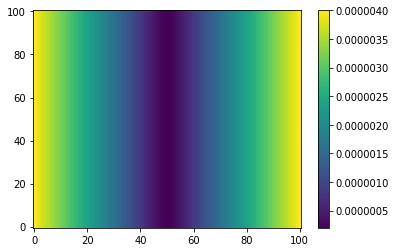

In [178]:
#plt.imshow(np.abs(rho1[1,0,:,:]),extent=(np.min(delta_mu_vals),np.max(delta_mu_vals),np.min(bvals),np.max(bvals)),aspect='auto',origin='lower')
plt.imshow(np.abs(rho1[1,0,:,:]),aspect='auto',origin='lower')
plt.colorbar()

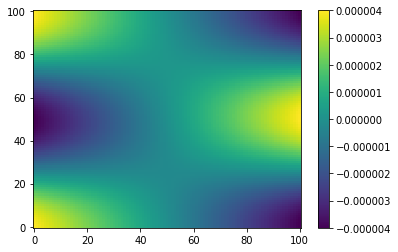

In [180]:
#plt.imshow(np.angle(rho1[1,0,:,:]),extent=(np.min(delta_mu_vals),np.max(delta_mu_vals),np.min(bvals),np.max(bvals)),aspect='auto',origin='lower')
plt.imshow(np.real(rho1[1,0,:,:]),aspect='auto',origin='lower')#,cmap='hsv')
plt.colorbar()

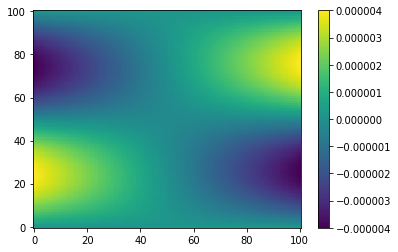

In [182]:
plt.imshow(np.imag(rho1[1,0,:,:]),aspect='auto',origin='lower')#,cmap='hsv')
plt.colorbar()

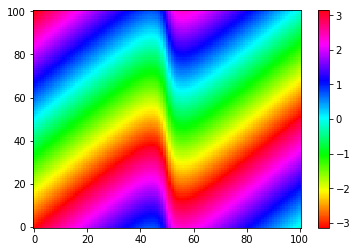

In [184]:
plt.imshow(np.angle(rho1[1,0,:,:]/bvals),aspect='auto',origin='lower',cmap='hsv')
plt.colorbar()